<a href="https://colab.research.google.com/github/NoeGille/UNet-on-fashion-mnist/blob/main/UNet_on_Florian's_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for UNet model found on

https://www.augustehoangduc.fr/comment-implementer-u-net-pour-faire-de-la-segmentation-dimage/

In [2]:
import keras.datasets.fashion_mnist as fashion_mnist

# Load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

(60000, 28, 28)
[9 0 0 ... 3 0 5]


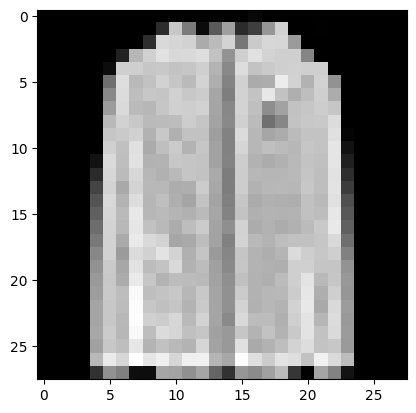

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import cv2

plt.imshow(choice(X_train), cmap='gray')
print(X_train.shape)
print(y_train)

In [12]:
def create_y(X):
  y = np.array([cv2.threshold(img, 8, 255, type=cv2.THRESH_BINARY)[1] for img in X])
  return np.array(y)

y_train = create_y(X_train)
y_test = create_y(X_test)

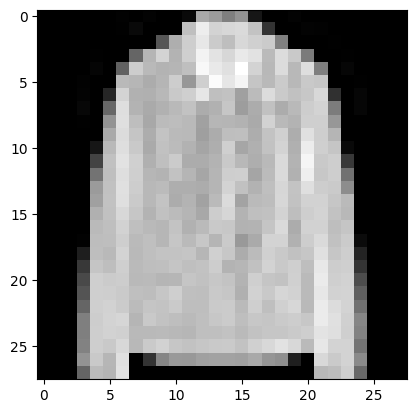

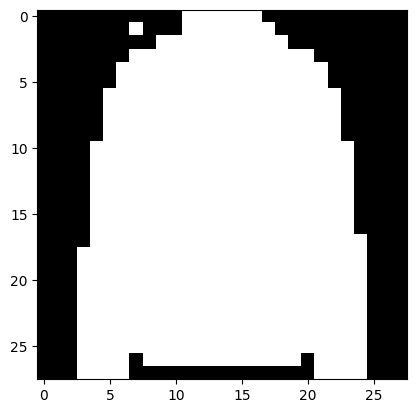

In [19]:
n = np.random.randint(0, 60000)
plt.imshow(X_train[n],cmap='gray')
plt.show()
plt.imshow(y_train[n],cmap='gray')
plt.show()

In [21]:
# CONSTANTS

IMG_SHAPE = (28, 28, 1)



In [22]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Concatenate, Input


def create_model():
    def DoubleConvolution(filters, inputs):
        """
        Double convolution layer used at every down sample and residual connection
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same', 
                   activation='relu')(inputs)
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same', activation='relu')(y)
        return y
    def DownSample(filters, inputs):
        """
        Reduce size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = MaxPooling2D(pool_size=(2,2), padding='valid')(inputs)
        y = DoubleConvolution(filters, y)
        return y
    
    def UpSample(filters, inputs):
        """
        Increase size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = UpSampling2D(size=(2,2))(inputs)
        y = Conv2D(filters=filters, kernel_size=(3,3), activation='relu', padding='same')(y)
        return y

    def ResidualConnection(filters, input_1, input_2):
        """
        Concatenate inputs of two blocks
        filters : outputs filter dimension
        input_1 : first input
        input_2 : second input
        """
        y = Concatenate(axis=-1)([input_1, input_2])
        y = DoubleConvolution(filters, y)
        return y
      
    input = Input(shape=(IMG_SHAPE))

    #shape =(28, 28, 1)
    Conv0 = DoubleConvolution(64, input)
    #shape =(28, 28, 64)
    Conv1 = DownSample(128, Conv0)
    #shape =(14, 14, 128)
    Conv2 = DownSample(256, Conv1)
    #shape =(7, 7, 256)
    
    UpConv1 = UpSample(128, Conv2)
    Res1 = ResidualConnection(128, Conv1, UpConv1)
    #shape =(14, 14, 128)

    UpConv0 = UpSample(128, Conv1)
    Res0 = ResidualConnection(64, Conv0, UpConv0)
    #shape =(28, 28, 64)

    output = Dense(units = 2, activation = 'softmax')(UpConv1) # shape = (28, 28, 2)

    return Model(input, output)

In [23]:
model = create_model()

In [24]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                             